In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import math
import json
import ccxt

In [2]:
def convert_tz(utc):
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    utc = utc.replace(tzinfo=from_zone).astimezone(to_zone)
    
    return utc

In [3]:
def get_date_list(start_date, end_date=None):
    '''
    Generate list of date to fetch 1 day iteration from fetch_ohlcv.
    '''
    if end_date == None:
        end_date = dt.date.today()
    
    num_day = (end_date - start_date).days
    date_list = [dt.date.today() - dt.timedelta(days = x) for x in range(num_day, 0, -1)]
    
    return date_list

In [4]:
def get_js_date(dt_date):
    '''
    Transform dt.datetime to JavaScript format.
    '''
    dt_datetime = dt.datetime(dt_date.year, dt_date.month, dt_date.day)
    js_datetime = dt_datetime.timestamp() * 1000
    
    return js_datetime

In [5]:
def get_ohlcv(symbol, date_list, timeframe, limit, exchange):
    df = pd.DataFrame(columns = ['time', 'open', 'high', 'low', 'close', 'volume'])

    for i in range(len(date_list)):
        since = get_js_date(date_list[i])
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        temp_df = pd.DataFrame(ohlcv)
        temp_df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
        temp_df['time'] = pd.to_datetime(temp_df['time'], unit='ms')
        temp_df['time'] = temp_df['time'].apply(lambda x: convert_tz(x))

        df = pd.concat([df, temp_df])

    df = df.reset_index(drop=True)

    return df

In [6]:
def get_timeframe(interval):
    timeframe_dict = {1440:'1d', 240:'4h', 60:'1h', 30:'30m', 15:'15m'}
    
    for i in timeframe_dict.keys():
        if interval % i == 0:
            min_interval = i
            break
            
    min_timeframe = timeframe_dict[min_interval]
    step = int(interval / min_interval)
            
    return min_timeframe, step

In [7]:
def group_timeframe(df, step):
    h_dict = {'time':[], 'open':[], 'high':[], 'low':[], 'close':[]}
    
    mod = len(df) % step
    if  mod != 0:
        df = df.iloc[:-mod, :]
        
    for i in [x for x in range(0, len(df), step)]:
        temp_df = df.iloc[i:i + step, :]
        h_dict['time'].append(temp_df['time'][i])
        h_dict['open'].append(temp_df['open'][i])
        h_dict['high'].append(max(temp_df['high']))
        h_dict['low'].append(min(temp_df['low']))
        h_dict['close'].append(temp_df['close'][i + 1])

    df = pd.DataFrame(h_dict)
    
    return df

In [8]:
def get_signal(df, signal, window):
    func_dict = {'tma': signal_tma}
    
    df = func_dict[signal](df, window)
    
    return df

In [9]:
def signal_tma(df, window):
    sub_interval = (window + 1) / 2
    
    # trunc ma to get minimum avg steps
    df['ma'] = df['close'].rolling(window=math.trunc(sub_interval)).mean()
    
    # round tma to reach window steps
    df['signal'] = df['ma'].rolling(window=int(np.round(sub_interval))).mean()
    
    df = df.drop(columns=['ma'])
    df = df.dropna().reset_index(drop=True)
    
    return df

In [10]:
def round_down_amount(amount, decimal):
    floor_amount = np.floor((amount * (10 ** decimal))) / (10 ** decimal)
    
    return floor_amount

### Config 

In [11]:
with open('../../../_keys/ftx/ftx_test_keys.json') as keys_file:
    keys_dict = json.load(keys_file)

In [12]:
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

In [13]:
base_currency = 'ETH'
quote_currency = 'USD'
decimal = 3

In [14]:
file_path = 'data'

In [15]:
signal = 'tma'
interval = 120
window = 50

In [16]:
start_date = dt.date(2019, 9, 16) # first available data
end_date = dt.date(2021, 7, 26)

### Get timeframe 

In [17]:
min_timeframe, step = get_timeframe(interval)

In [18]:
limit = int(1440 / (interval / step))

### Get data

In [19]:
symbol = '{}/{}'.format(base_currency, quote_currency)

In [20]:
date_list = get_date_list(start_date, end_date)

In [21]:
raw_df = get_ohlcv(symbol, date_list, min_timeframe, limit)

In [22]:
raw_df

,time,open,high,low,close,volume
0,2019-09-25 00:00:00+07:00,189.24,189.67,187.94,188.99,9.918450e+04
1,2019-09-25 01:00:00+07:00,189.03,189.55,164.28,164.43,1.380150e+03
2,2019-09-25 02:00:00+07:00,163.67,173.86,154.49,169.29,7.696610e+05
3,2019-09-25 03:00:00+07:00,169.36,172.08,163.08,165.68,6.666155e+05
4,2019-09-25 04:00:00+07:00,165.64,170.34,162.99,167.98,1.498144e+04
...,...,...,...,...,...,...
16291,2021-08-03 19:00:00+07:00,2488.70,2518.00,2455.70,2501.70,2.758799e+07
16292,2021-08-03 20:00:00+07:00,2501.70,2522.60,2500.00,2513.30,9.109476e+06
16293,2021-08-03 21:00:00+07:00,2513.30,2539.70,2506.60,2513.10,1.744603e+07
16294,2021-08-03 22:00:00+07:00,2513.10,2517.60,2474.80,2496.20,2.532835e+07


### Group timeframe

In [23]:
df = group_timeframe(raw_df, step)

In [24]:
df

,time,open,high,low,close
0,2019-09-25 00:00:00+07:00,189.24,189.67,164.28,164.43
1,2019-09-25 02:00:00+07:00,163.67,173.86,154.49,165.68
2,2019-09-25 04:00:00+07:00,165.64,170.89,162.99,168.85
3,2019-09-25 06:00:00+07:00,168.87,172.05,165.37,169.19
4,2019-09-25 08:00:00+07:00,169.09,174.97,169.09,171.06
...,...,...,...,...,...
8143,2021-08-03 14:00:00+07:00,2461.60,2499.70,2444.00,2483.80
8144,2021-08-03 16:00:00+07:00,2483.80,2524.20,2469.70,2512.10
8145,2021-08-03 18:00:00+07:00,2512.10,2518.00,2455.70,2501.70
8146,2021-08-03 20:00:00+07:00,2501.70,2539.70,2500.00,2513.10


### Get signal

In [25]:
df = get_signal(df, signal, window)

In [26]:
df

,time,open,high,low,close,signal
0,2019-09-29 02:00:00+07:00,173.74,174.56,172.90,174.23,167.553631
1,2019-09-29 04:00:00+07:00,174.19,175.40,170.60,173.23,167.648892
2,2019-09-29 06:00:00+07:00,173.26,174.81,172.71,173.56,167.755585
3,2019-09-29 08:00:00+07:00,173.56,174.01,171.47,171.47,167.871892
4,2019-09-29 10:00:00+07:00,171.70,172.24,170.74,171.30,168.004923
...,...,...,...,...,...,...
8094,2021-08-03 14:00:00+07:00,2461.60,2499.70,2444.00,2483.80,2542.250615
8095,2021-08-03 16:00:00+07:00,2483.80,2524.20,2469.70,2512.10,2547.088923
8096,2021-08-03 18:00:00+07:00,2512.10,2518.00,2455.70,2501.70,2551.521538
8097,2021-08-03 20:00:00+07:00,2501.70,2539.70,2500.00,2513.10,2555.475231


### Run simulation 

In [27]:
simu_df = df.copy()

In [28]:
budget = 100
last_action_price = 0
last_action_amount = 0

In [29]:
signal_dict = {'action':[], 'action_price':[], 'budget':[], 'profit':[], 'drawdown':[]}

for i in range(len(simu_df)):
    if df['close'][i] > df['signal'][i]:
        action = 'buy'
    elif df['close'][i] < df['signal'][i]:
        action = 'sell'
    else:
        action = signal_dict['action'][-1]
    
    if i > 0:
        if action != signal_dict['action'][-1]:
            if last_action_price > 0:
                if action == 'buy':
                    profit = (last_action_price - df['close'][i]) * last_action_amount
                elif action == 'sell':
                    profit = (df['close'][i] - last_action_price) * last_action_amount

            last_action_price = df['close'][i]
            last_action_amount = round_down_amount(budget / last_action_price, decimal)
            
            budget += profit
        else:
            profit = 0
    else:
        profit = 0
        
    
    if last_action_price > 0:
        if action == 'buy':
            drawdown = (df['low'][i] - last_action_price) / last_action_price
        elif action == 'sell':
            drawdown = (last_action_price - df['high'][i]) / last_action_price
    else:
        drawdown = 0
        max_drawdown = 0
        
    signal_dict['action'].append(action)
    signal_dict['action_price'].append(last_action_price)
    signal_dict['budget'].append(budget)
    signal_dict['profit'].append(profit)
    signal_dict['drawdown'].append(drawdown)

In [30]:
budget

4696.664240000002

In [31]:
for s in signal_dict.keys():
    simu_df[s] = signal_dict[s]

In [32]:
simu_df.to_csv('simulation.csv', index=False)

### Viz 

In [33]:
import matplotlib.pyplot as plt

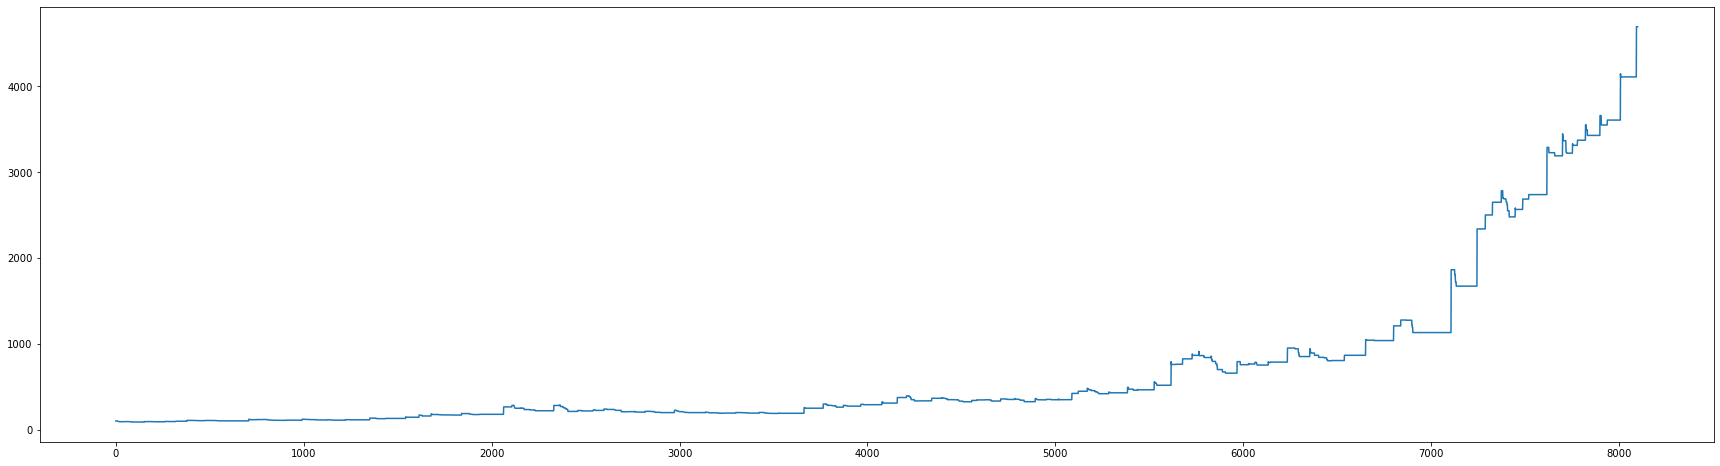

In [34]:
fig, ax = plt.subplots(figsize=(30, 8))
ax.plot(simu_df['budget'])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   2.,   1.,   2.,
          0.,   0.,   1.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          2.,   2.,   2.,   1.,   1.,   1.,   0.,   3.,   1.,   4.,   3.,
          3.,   2.,   2.,   1.,   3.,   4.,   3.,   4.,   5.,   4.,   5.,
         11.,   5.,   3.,   8.,   7.,   6.,   3.,  12.,  15.,  14.,   8.,
         24.,  19.,  19.,  17.,  28.,  23.,  25.,  33.,  31.,  35.,  52.,
         39.,  54.,  69.,  71.,  77.,  76.,  92.,  98., 101., 108., 116.,
        103., 159., 115., 108., 131.,  92.,  90.,  84.,  87.,  83.,  73.,
         66.,  73.,  65.,  69.,  71.,  74.,  83.,  72.,  53.,  71.,  62.,
         73.,  48.,  52.,  59.,  53.,  59.,  55.,  50.,  51.,  43.,  60.,
         48.,  54.,  41.,  44.,  52., 

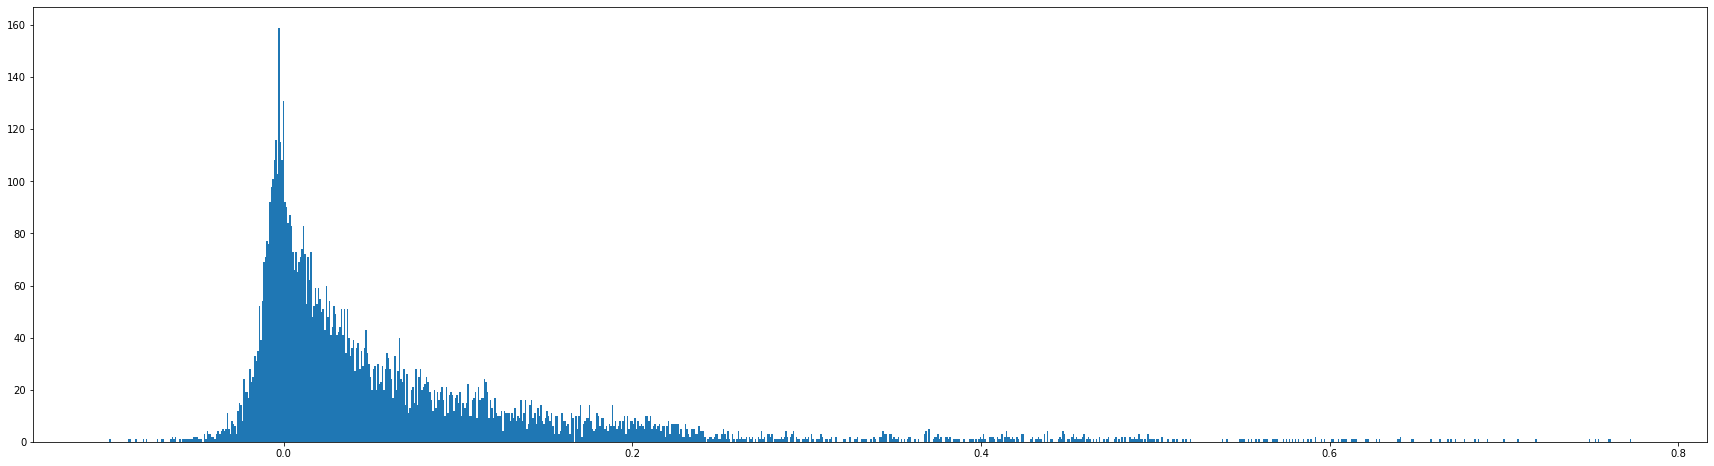

In [35]:
fig, ax = plt.subplots(figsize=(30,8))
ax.hist(simu_df['drawdown'], bins=1000)

In [36]:
simu_df['drawdown'].describe()

count    8099.000000
mean        0.065778
std         0.105249
min        -0.099896
25%         0.000768
50%         0.028383
75%         0.091218
max         0.773043
Name: drawdown, dtype: float64